In [1]:
from pathlib import Path
import pandas as pd
import torch
import pickle
import os
import numpy as np

In [2]:
predictions = np.load('predictions.npy')
predictions.shape

(112830, 176)

In [3]:
labels = np.load('labels.npy')
labels.shape

(112830, 176)

In [4]:
binarizer_file = Path("../../../models/multilabel_binarizer.pkl")
with open(binarizer_file, 'rb') as f:
    multi_binarizer = pickle.load(f)
    
multi_binarizer

MultiLabelBinarizer()

<Axes: >

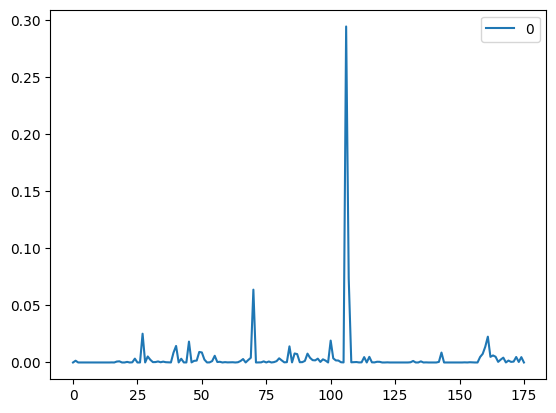

In [5]:
pd.DataFrame(predictions[103000]).plot()

In [6]:
multi_binarizer.classes_

array(['acc-phys', 'adap-org', 'alg-geom', 'ao-sci', 'astro-ph',
       'astro-ph.CO', 'astro-ph.EP', 'astro-ph.GA', 'astro-ph.HE',
       'astro-ph.IM', 'astro-ph.SR', 'atom-ph', 'bayes-an', 'chao-dyn',
       'chem-ph', 'cmp-lg', 'comp-gas', 'cond-mat', 'cond-mat.dis-nn',
       'cond-mat.mes-hall', 'cond-mat.mtrl-sci', 'cond-mat.other',
       'cond-mat.quant-gas', 'cond-mat.soft', 'cond-mat.stat-mech',
       'cond-mat.str-el', 'cond-mat.supr-con', 'cs.AI', 'cs.AR', 'cs.CC',
       'cs.CE', 'cs.CG', 'cs.CL', 'cs.CR', 'cs.CV', 'cs.CY', 'cs.DB',
       'cs.DC', 'cs.DL', 'cs.DM', 'cs.DS', 'cs.ET', 'cs.FL', 'cs.GL',
       'cs.GR', 'cs.GT', 'cs.HC', 'cs.IR', 'cs.IT', 'cs.LG', 'cs.LO',
       'cs.MA', 'cs.MM', 'cs.MS', 'cs.NA', 'cs.NE', 'cs.NI', 'cs.OH',
       'cs.OS', 'cs.PF', 'cs.PL', 'cs.RO', 'cs.SC', 'cs.SD', 'cs.SE',
       'cs.SI', 'cs.SY', 'dg-ga', 'econ.EM', 'econ.GN', 'econ.TH',
       'eess.AS', 'eess.IV', 'eess.SP', 'eess.SY', 'funct-an', 'gr-qc',
       'hep-ex', 'hep-lat',

In [7]:
# df = pd.DataFrame(predictions, columns=multi_binarizer.classes_)
df = pd.DataFrame(predictions)

# Compute the column-wise summed probabilities
summed_probabilities = df.sum()
df.shape

(112830, 176)

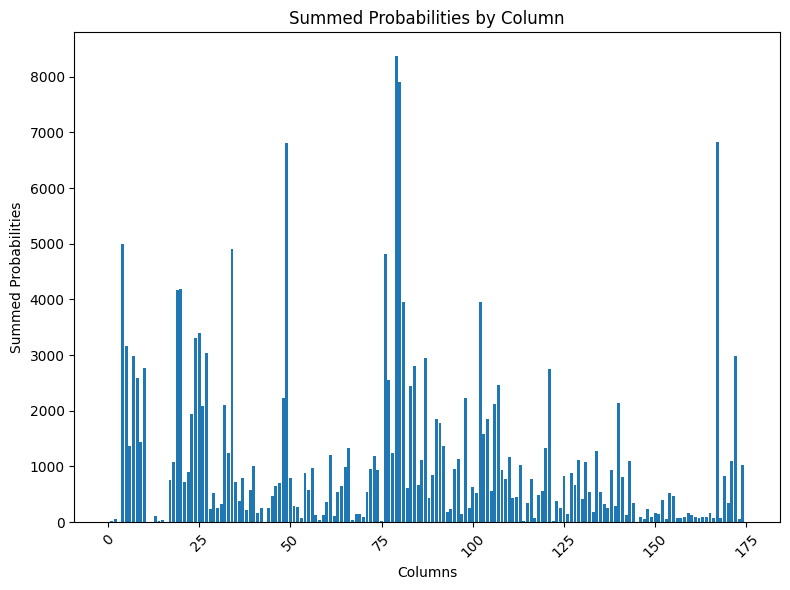

In [8]:
import matplotlib.pyplot as plt

# Plot as a bar plot
plt.figure(figsize=(8, 6))
plt.bar(summed_probabilities.index, summed_probabilities)
plt.xlabel('Columns')
plt.ylabel('Summed Probabilities')
plt.title('Summed Probabilities by Column')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

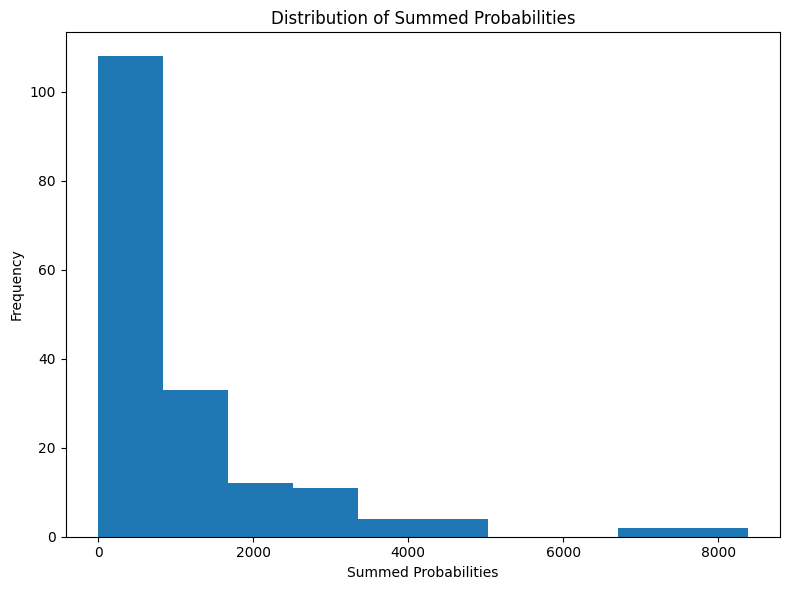

In [9]:
# Plot as a histogram
plt.figure(figsize=(8, 6))
plt.hist(summed_probabilities, bins=10)
plt.xlabel('Summed Probabilities')
plt.ylabel('Frequency')
plt.title('Distribution of Summed Probabilities')
plt.tight_layout()
plt.show()

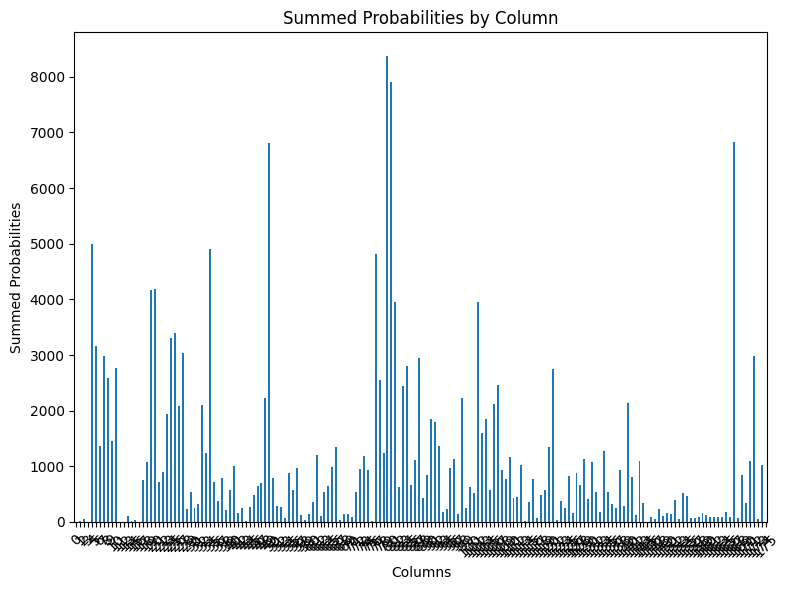

In [10]:
summed_probabilities.plot(kind='bar', figsize=(8, 6))
plt.xlabel('Columns')
plt.ylabel('Summed Probabilities')
plt.title('Summed Probabilities by Column')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

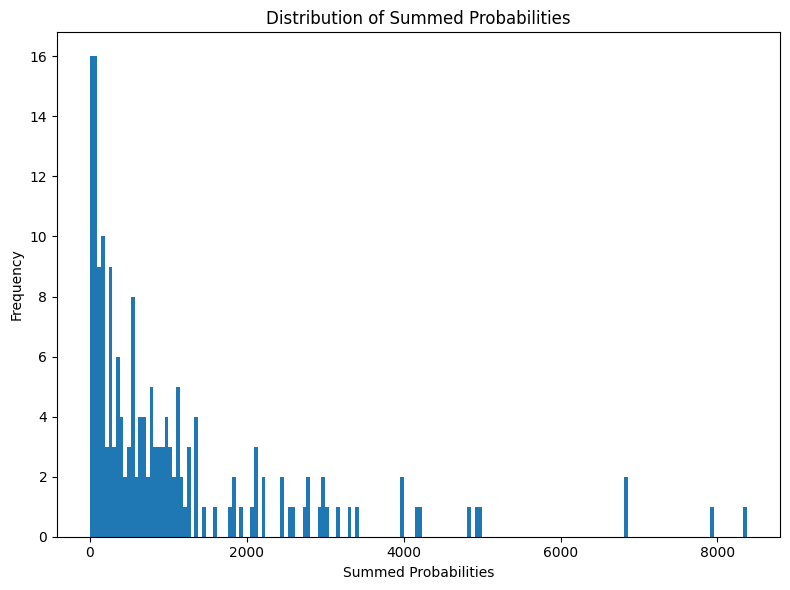

In [11]:
# Plot as a histogram using pandas
summed_probabilities.plot(kind='hist', bins=len(multi_binarizer.classes_), figsize=(8, 6))
plt.xlabel('Summed Probabilities')
plt.ylabel('Frequency')
plt.title('Distribution of Summed Probabilities')
plt.tight_layout()
plt.show()

In [5]:
from logging import Logger, StreamHandler

logger = Logger(__name__)
logger.addHandler(StreamHandler())

In [6]:
from sklearn.metrics import hamming_loss, precision_score, recall_score, f1_score, classification_report, jaccard_score

def print_metrics_for_index(target_index: int, threshold: float=0.1):
    preds = predictions[target_index]

    logger.info(f"where matches")
    preds_above_threshold = np.where(preds > threshold)[0]
    logger.info(preds_above_threshold)
    targets_above_threshold = np.where(labels[target_index] > threshold)[0]
    logger.info(targets_above_threshold)
    
    logger.info(f"Common in both {np.intersect1d(preds_above_threshold, targets_above_threshold)}")

    where = np.where(preds > threshold)[0]

    binary_preds = np.zeros_like(preds)
    binary_preds[where] = 1.


    logger.info(f"\n\nhamming loss {hamming_loss(y_true=labels[target_index], y_pred=binary_preds)}")
#     logger.info(f"\n\nhamming loss {hamming_loss(y_true=labels[target_index], y_pred=preds)}")

    logger.info(f"\nprecision {precision_score(y_true=labels[target_index], y_pred=binary_preds, average='macro')}")

    logger.info(f"\nrecall {recall_score(y_true=labels[target_index], y_pred=binary_preds, average='macro')}")

    logger.info(f"\nf1 macro {f1_score(y_true=labels[target_index], y_pred=binary_preds, average='macro')}\n\n")

    logger.info(classification_report(labels[target_index], y_pred=binary_preds))
    
    original = multi_binarizer.inverse_transform(np.array([labels[target_index]]))
    predicted = multi_binarizer.inverse_transform(np.array([binary_preds]))
    
    logger.info(f"Original Labels: {original}")
    logger.info(f"Predicted Labels: {predicted}")
    logger.info(f"Overlapping Labels: {set(original[0]) & set(predicted[0])}")
    
    return labels[target_index], binary_preds

### All Samples Accuracy

In [7]:
from sklearn.preprocessing import Binarizer

def top_n_accuracy(range_start:int, range_end:int, threshold=0.1, top=1):
    binarizer = Binarizer(threshold=threshold)

    preds1 = binarizer.transform(predictions)

    matches = np.logical_and(labels[range_start:range_end], preds1[range_start:range_end])
    
    # Count the number of matches for each sample
    match_counts = np.sum(matches, axis=1)

    # Calculate the accuracy
    accuracy = np.mean(match_counts >= top)
    

    # Calculate the accuracy
#     accuracy = np.mean(np.any(matches, axis=1))
    logger.info(f"Top {top} accuracy: {accuracy} @ threshold {threshold}")

In [173]:
for t in [1,2,3,4]:
    top_n_accuracy(range_start=0, range_end=len(labels), threshold=0.0001, top=t)

Top 1 accuracy: 0.9998493308517238 @ threshold 0.0001
Top 2 accuracy: 0.45324824957901266 @ threshold 0.0001
Top 3 accuracy: 0.16318355047416466 @ threshold 0.0001
Top 4 accuracy: 0.04988035097048657 @ threshold 0.0001


In [174]:
for t in [1,2,3,4]:
    top_n_accuracy(range_start=0, range_end=len(labels), threshold=0.001, top=t)

Top 1 accuracy: 0.9987414694673402 @ threshold 0.001
Top 2 accuracy: 0.4502880439599397 @ threshold 0.001
Top 3 accuracy: 0.1606044491713197 @ threshold 0.001
Top 4 accuracy: 0.04821412744837366 @ threshold 0.001


In [175]:
for t in [1,2,3,4]:
    top_n_accuracy(range_start=0, range_end=len(labels), threshold=0.01, top=t)

Top 1 accuracy: 0.989417708056368 @ threshold 0.01
Top 2 accuracy: 0.43002747496233273 @ threshold 0.01
Top 3 accuracy: 0.14512984135424975 @ threshold 0.01
Top 4 accuracy: 0.040015953203935126 @ threshold 0.01


In [164]:
for t in [1,2,3,4]:
    top_n_accuracy(range_start=0, range_end=len(labels), threshold=0.05, top=t)

Top 1 accuracy: 0.9568288575733405 @ threshold 0.05
Top 2 accuracy: 0.3744925994859523 @ threshold 0.05
Top 3 accuracy: 0.10901356022334485 @ threshold 0.05
Top 4 accuracy: 0.024816095010192326 @ threshold 0.05


In [165]:
for t in [1,2,3,4]:
    top_n_accuracy(range_start=0, range_end=len(labels), threshold=0.1, top=t)

Top 1 accuracy: 0.9236993707347336 @ threshold 0.1
Top 2 accuracy: 0.3256669325533989 @ threshold 0.1
Top 3 accuracy: 0.08332890188779579 @ threshold 0.1
Top 4 accuracy: 0.015908889479748296 @ threshold 0.1


In [166]:
for t in [1,2,3,4]:
    top_n_accuracy(range_start=0, range_end=len(labels), threshold=0.15, top=t)

Top 1 accuracy: 0.8927324293184437 @ threshold 0.15
Top 2 accuracy: 0.285810511388815 @ threshold 0.15
Top 3 accuracy: 0.06463706461047594 @ threshold 0.15
Top 4 accuracy: 0.010564566161481876 @ threshold 0.15


In [167]:
for t in [1,2,3,4]:
    top_n_accuracy(range_start=0, range_end=len(labels), threshold=0.2, top=t)

Top 1 accuracy: 0.8632190020384649 @ threshold 0.2
Top 2 accuracy: 0.2498183107329611 @ threshold 0.2
Top 3 accuracy: 0.05003988300983781 @ threshold 0.2
Top 4 accuracy: 0.007170078879730568 @ threshold 0.2


In [168]:
for t in [1,2,3,4]:
    top_n_accuracy(range_start=0, range_end=len(labels), threshold=0.3, top=t)

Top 1 accuracy: 0.801675086413188 @ threshold 0.3
Top 2 accuracy: 0.18854028183993618 @ threshold 0.3
Top 3 accuracy: 0.029380483913852697 @ threshold 0.3
Top 4 accuracy: 0.003004520074448285 @ threshold 0.3


In [169]:
for t in [1,2,3,4]:
    top_n_accuracy(range_start=0, range_end=len(labels), threshold=0.4, top=t)

Top 1 accuracy: 0.7371709651688381 @ threshold 0.4
Top 2 accuracy: 0.1377647788708677 @ threshold 0.4
Top 3 accuracy: 0.01601524417264912 @ threshold 0.4
Top 4 accuracy: 0.0011787645129841353 @ threshold 0.4


In [170]:
for t in [1,2,3,4]:
    top_n_accuracy(range_start=0, range_end=len(labels), threshold=0.5, top=t)

Top 1 accuracy: 0.6660462642914119 @ threshold 0.5
Top 2 accuracy: 0.09455818487990783 @ threshold 0.5
Top 3 accuracy: 0.0076398121067092085 @ threshold 0.5
Top 4 accuracy: 0.0003102011876274041 @ threshold 0.5


In [171]:
for t in [1,2,3,4]:
    top_n_accuracy(range_start=0, range_end=len(labels), threshold=0.6, top=t)

Top 1 accuracy: 0.5845253921829301 @ threshold 0.6
Top 2 accuracy: 0.059478862004785964 @ threshold 0.6
Top 3 accuracy: 0.002889302490472392 @ threshold 0.6
Top 4 accuracy: 7.976601967561819e-05 @ threshold 0.6


### Individual Sample Accuracy

In [190]:
target_index = 40001
threshold = 0.4

lab, pred = print_metrics_for_index(target_index=target_index, threshold=threshold)

where matches
[19 20]
[19]
Common in both [19]


hamming loss 0.005681818181818182

precision 0.75

recall 0.9971428571428571

f1 macro 0.8319006685768864


              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00       175
         1.0       0.50      1.00      0.67         1

    accuracy                           0.99       176
   macro avg       0.75      1.00      0.83       176
weighted avg       1.00      0.99      1.00       176

Original Labels: [('cond-mat.mes-hall',)]
Predicted Labels: [('cond-mat.mes-hall', 'cond-mat.mtrl-sci')]
Overlapping Labels: {'cond-mat.mes-hall'}
